In [3]:
import numpy as np  
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax, AdamW
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50


2025-05-16 13:37:39.521412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747402659.718524      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747402659.774548      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def make_dataframes(sdir):
    dataset_names= ['train', 'test' ,'valid'] 
    train_path=os.path.join(sdir, 'train') #/kaggle/input/autism/autism/(train or test or valid)
    test_path=os.path.join(sdir, 'test')
    valid_path=os.path.join(sdir, 'valid')
    path_list=[train_path, test_path, valid_path]   
    zip_list=zip(dataset_names, path_list) 
    
    # generate train_df, test_df, valid_df
    for dataset, setpath in zip_list:
        filepaths=[]
        labels=[]
        classes=sorted(os.listdir(setpath))
        for klass in classes:
            classpath=os.path.join(setpath, klass)
            flist=sorted(os.listdir(classpath))           
            desc=f'{dataset:6s}-{klass:13s}'            
            for f in tqdm(flist, ncols=130, desc=desc):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1)
        if dataset =='train':
            train_df=df
        elif dataset == 'test':
            test_df=df
        else:
            valid_df=df
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count, sdir
    

In [5]:
train_df, test_df, valid_df, classes, class_count, sdir=make_dataframes("/kaggle/input/autism-modified/autism")

valid -non_autistic : 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 550433.60it/s]


number of classes in processed dataset=  2
the maximum files in any class in train_df is  1246   the minimum files in any class in train_df is  1228
train_df length:  2474   test_df length:  200   valid_df length:  200
average image height=  333   average image width=  288  aspect ratio h/w=  1.15625


In [6]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    
    trgen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        zoom_range=0.3,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.7, 1.3],
        horizontal_flip=True,
        shear_range=0.2,
        fill_mode='nearest'
    )
    t_and_v_gen=ImageDataGenerator(rescale=1./255)

    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this ensures that we go through all the sample in the test set exactly once.
    
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

    
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=20
img_size=(224,224)
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 2474 validated image filenames belonging to 2 classes.           for train generator 
Found 200 validated image filenames belonging to 2 classes.            for valid generator 
Found 200 validated image filenames belonging to 2 classes.            for test generator 
test batch size:  50   test steps:  4  number of classes :  2


In [13]:
def make_model(img_size):
  #  print('Enter the initial model learning rate. I recommend .002', flush=True)
  #  lr=float(input(' '))
    img_shape=(img_size[0], img_size[1], 3)
    base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
    # Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
    base_model.trainable=True
    l2 = regularizers.l2(9e-6)
    x = base_model.output
    # x = BatchNormalization()(x)
    # x = Dense(512, activation='relu', kernel_regularizer=l2)(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.5)(x)
    # x = Dense(128, activation='relu', kernel_regularizer=l2)(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(class_count, activation='softmax')(x)
    
    model=Model(inputs=base_model.input, outputs=output)
    loss = CategoricalCrossentropy(label_smoothing=0.05)
    model.compile(Adamax(learning_rate=0.0015), loss=loss, metrics=['accuracy'])
    return model

model=make_model(img_size)

In [45]:
from tensorflow.keras.callbacks import Callback

class TestAccuracyEarlyStopping(Callback):
    def __init__(self, test_data, patience=5):
        super(TestAccuracyEarlyStopping, self).__init__()
        self.test_data = test_data
        self.patience = patience
        self.best_val_accuracy = 0
        self.best_test_accuracy = 0
        self.epochs_no_improve = 0

    def on_epoch_end(self, epoch, logs=None):
        # Get validation accuracy from logs
        val_accuracy = logs.get('val_accuracy')

        # Evaluate the model on the test data
        test_loss, test_accuracy = self.model.evaluate(self.test_data, verbose=0)

        # Check if validation accuracy has improved
        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            
            # Check if test accuracy has decreased
            if test_accuracy < self.best_test_accuracy:
                self.epochs_no_improve += 1
                print(f"\n🚨 Test accuracy dropped to {test_accuracy:.4f} from {self.best_test_accuracy:.4f}")
            else:
                self.best_test_accuracy = test_accuracy
                self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
        
        # Stop training if patience is exceeded
        if self.epochs_no_improve >= self.patience:
            print(f"\n🛑 Early stopping: Test accuracy did not improve for {self.patience} consecutive epochs.")
            self.model.stop_training = True

        print(f"✅ Epoch {epoch+1}: Val Accuracy = {val_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/model_2.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1, mode='min')
#test_early_stopping = TestAccuracyEarlyStopping(test_data=test_gen, patience=15)
reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
epochs = 40

In [16]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1,   validation_data=valid_gen,
                initial_epoch=0, callbacks=[early_stop,reduce_lr,checkpoint])

Epoch 1/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.6838 - loss: 0.7221
Epoch 1: val_loss improved from inf to 0.77267, saving model to /kaggle/working/model_2.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 287ms/step - accuracy: 0.6838 - loss: 0.7221 - val_accuracy: 0.5850 - val_loss: 0.7727 - learning_rate: 0.0015
Epoch 2/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.7200 - loss: 0.6875
Epoch 2: val_loss did not improve from 0.77267
124/124 ━━━━━━━━━━━━━━━━━━━━ 35s 267ms/step - accuracy: 0.7199 - loss: 0.6873 - val_accuracy: 0.6950 - val_loss: 0.8012 - learning_rate: 0.0015
Epoch 3/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7450 - loss: 0.6272
Epoch 3: val_loss improved from 0.77267 to 0.67722, saving model to /kaggle/working/model_2.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - accuracy: 0.7451 - loss: 0.6272 - val_accuracy: 0.7800 - val_loss: 0.6772 - learning_rate: 0.0015
Epoch 4/40
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy:

KeyboardInterrupt: 

In [ ]:
x_val, y_val = next(valid_gen)
preds = model.predict(x_val)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(y_val, axis=1)

print("Predictions:", pred_classes[:20])
print("True Labels:", true_classes[:20])


In [10]:

test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 357ms/step - accuracy: 0.8787 - loss: 0.3389
Test Accuracy: 90.00%


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step
there were 16 errors in 200 tests for an accuracy of  92.00


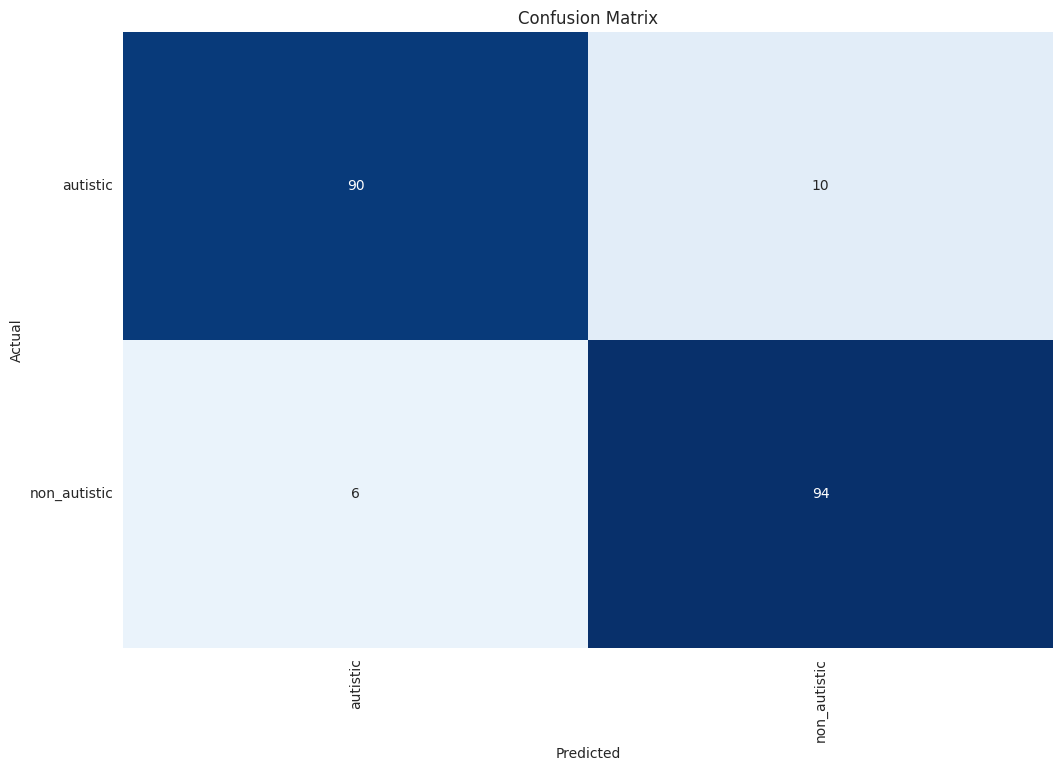

Classification Report:
----------------------
               precision    recall  f1-score   support

    autistic     0.9375    0.9000    0.9184       100
non_autistic     0.9038    0.9400    0.9216       100

    accuracy                         0.9200       200
   macro avg     0.9207    0.9200    0.9200       200
weighted avg     0.9207    0.9200    0.9200       200



In [55]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

In [56]:
working_dir=r'/kaggle/working/'
subject='autism-B5' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 

model was saved as  /kaggle/working/autism-B5_92.0.h5
